# Fast Food Nutrition Data Mining
For the DATA 602 Group Project, we intend to identify relationships between menu items of fast food restaurants, their nutritional information, and Weight Watchers Points. We initially got our data from [Kaggle](https://www.kaggle.com/datasets/joebeachcapital/fast-food). However, we noticed that the Weight Watcher Points in this data were more than the actual Weight Watcher Points obtainable. We also noticed that the Weight Watcher Points were oddly similar to the value of the calories for each menu item.

In [1]:
# import modules
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from io import StringIO
import seaborn as sns
import pandas as pd
import numpy as np
import requests
import time

## Initial Data

In [2]:
# create new folders in the pwd called .kaggle and tmp
! mkdir .kaggle tmp
# access my Kaggle API key - we will expire this token two weeks after the project submission date
# store the kaggle key as a json file in the .kaggle folder
! echo {"username":"itunuoluwaolowoye", "key":"4fca1efc29387bf70af9d637ef19c3b9"} > .kaggle/kaggle.json
# pip install kaggle and pandas if you haven't already
! pip install kaggle pandas
# download the required dataset
! kaggle datasets download joebeachcapital/fast-food
# move the dataset to tmp
! move fast-food.zip tmp/fast-food-dataset.zip
# unzip the download
# LINUX
# ! unzip tmp/superstore-dataset.zip -d tmp/
# WINDOWS
! tar -xf tmp/fast-food-dataset.zip -C tmp/

Dataset URL: https://www.kaggle.com/datasets/joebeachcapital/fast-food
License(s): DbCL-1.0




  0%|          | 0.00/40.3k [00:00<?, ?B/s]
100%|██████████| 40.3k/40.3k [00:00<00:00, 808kB/s]


        1 file(s) moved.


In [3]:
# read downloaded data
fast_food_df = pd.read_csv('tmp/FastFoodNutritionMenuV3.csv')

In [4]:
# set index
fast_food_df.set_index(['Company', 'Item'], inplace=True)

In [5]:
# convert columns to numeric
for col in fast_food_df.columns:
    fast_food_df[col] = fast_food_df[col].replace('<5', 4.99).replace('<1', 0.99).replace('\xa0', np.nan).astype(float)

In [6]:
# check numerical summaries of the Weight Watcher Points
fast_food_df.groupby('Company')['Weight Watchers\nPnts'].agg(['min', 'median', 'mean', 'max'])

,min,median,mean,max
Company,,,,
Burger King,0.0,341.0,381.011173,1192.0
KFC,0.0,202.0,234.901376,1220.0
McDonald’s,0.0,267.0,306.426154,1317.0
Pizza Hut,NaN,NaN,NaN,NaN
Taco Bell,NaN,NaN,NaN,NaN
Wendy’s,0.0,337.5,342.850649,1058.0


In [7]:
# check the number of records of each restaurant's menu
fast_food_df.groupby('Company').size()

Company
Burger King    190
KFC            218
McDonald’s     328
Pizza Hut       74
Taco Bell      183
Wendy’s        154
dtype: int64

In [8]:
# check for null Weight Watcher Points in each restaurant
fast_food_df.groupby('Company')['Weight Watchers\nPnts'].apply(lambda x: x.isnull().sum())

Company
Burger King     11
KFC              0
McDonald’s       3
Pizza Hut       74
Taco Bell      183
Wendy’s          0
Name: Weight Watchers\nPnts, dtype: int64

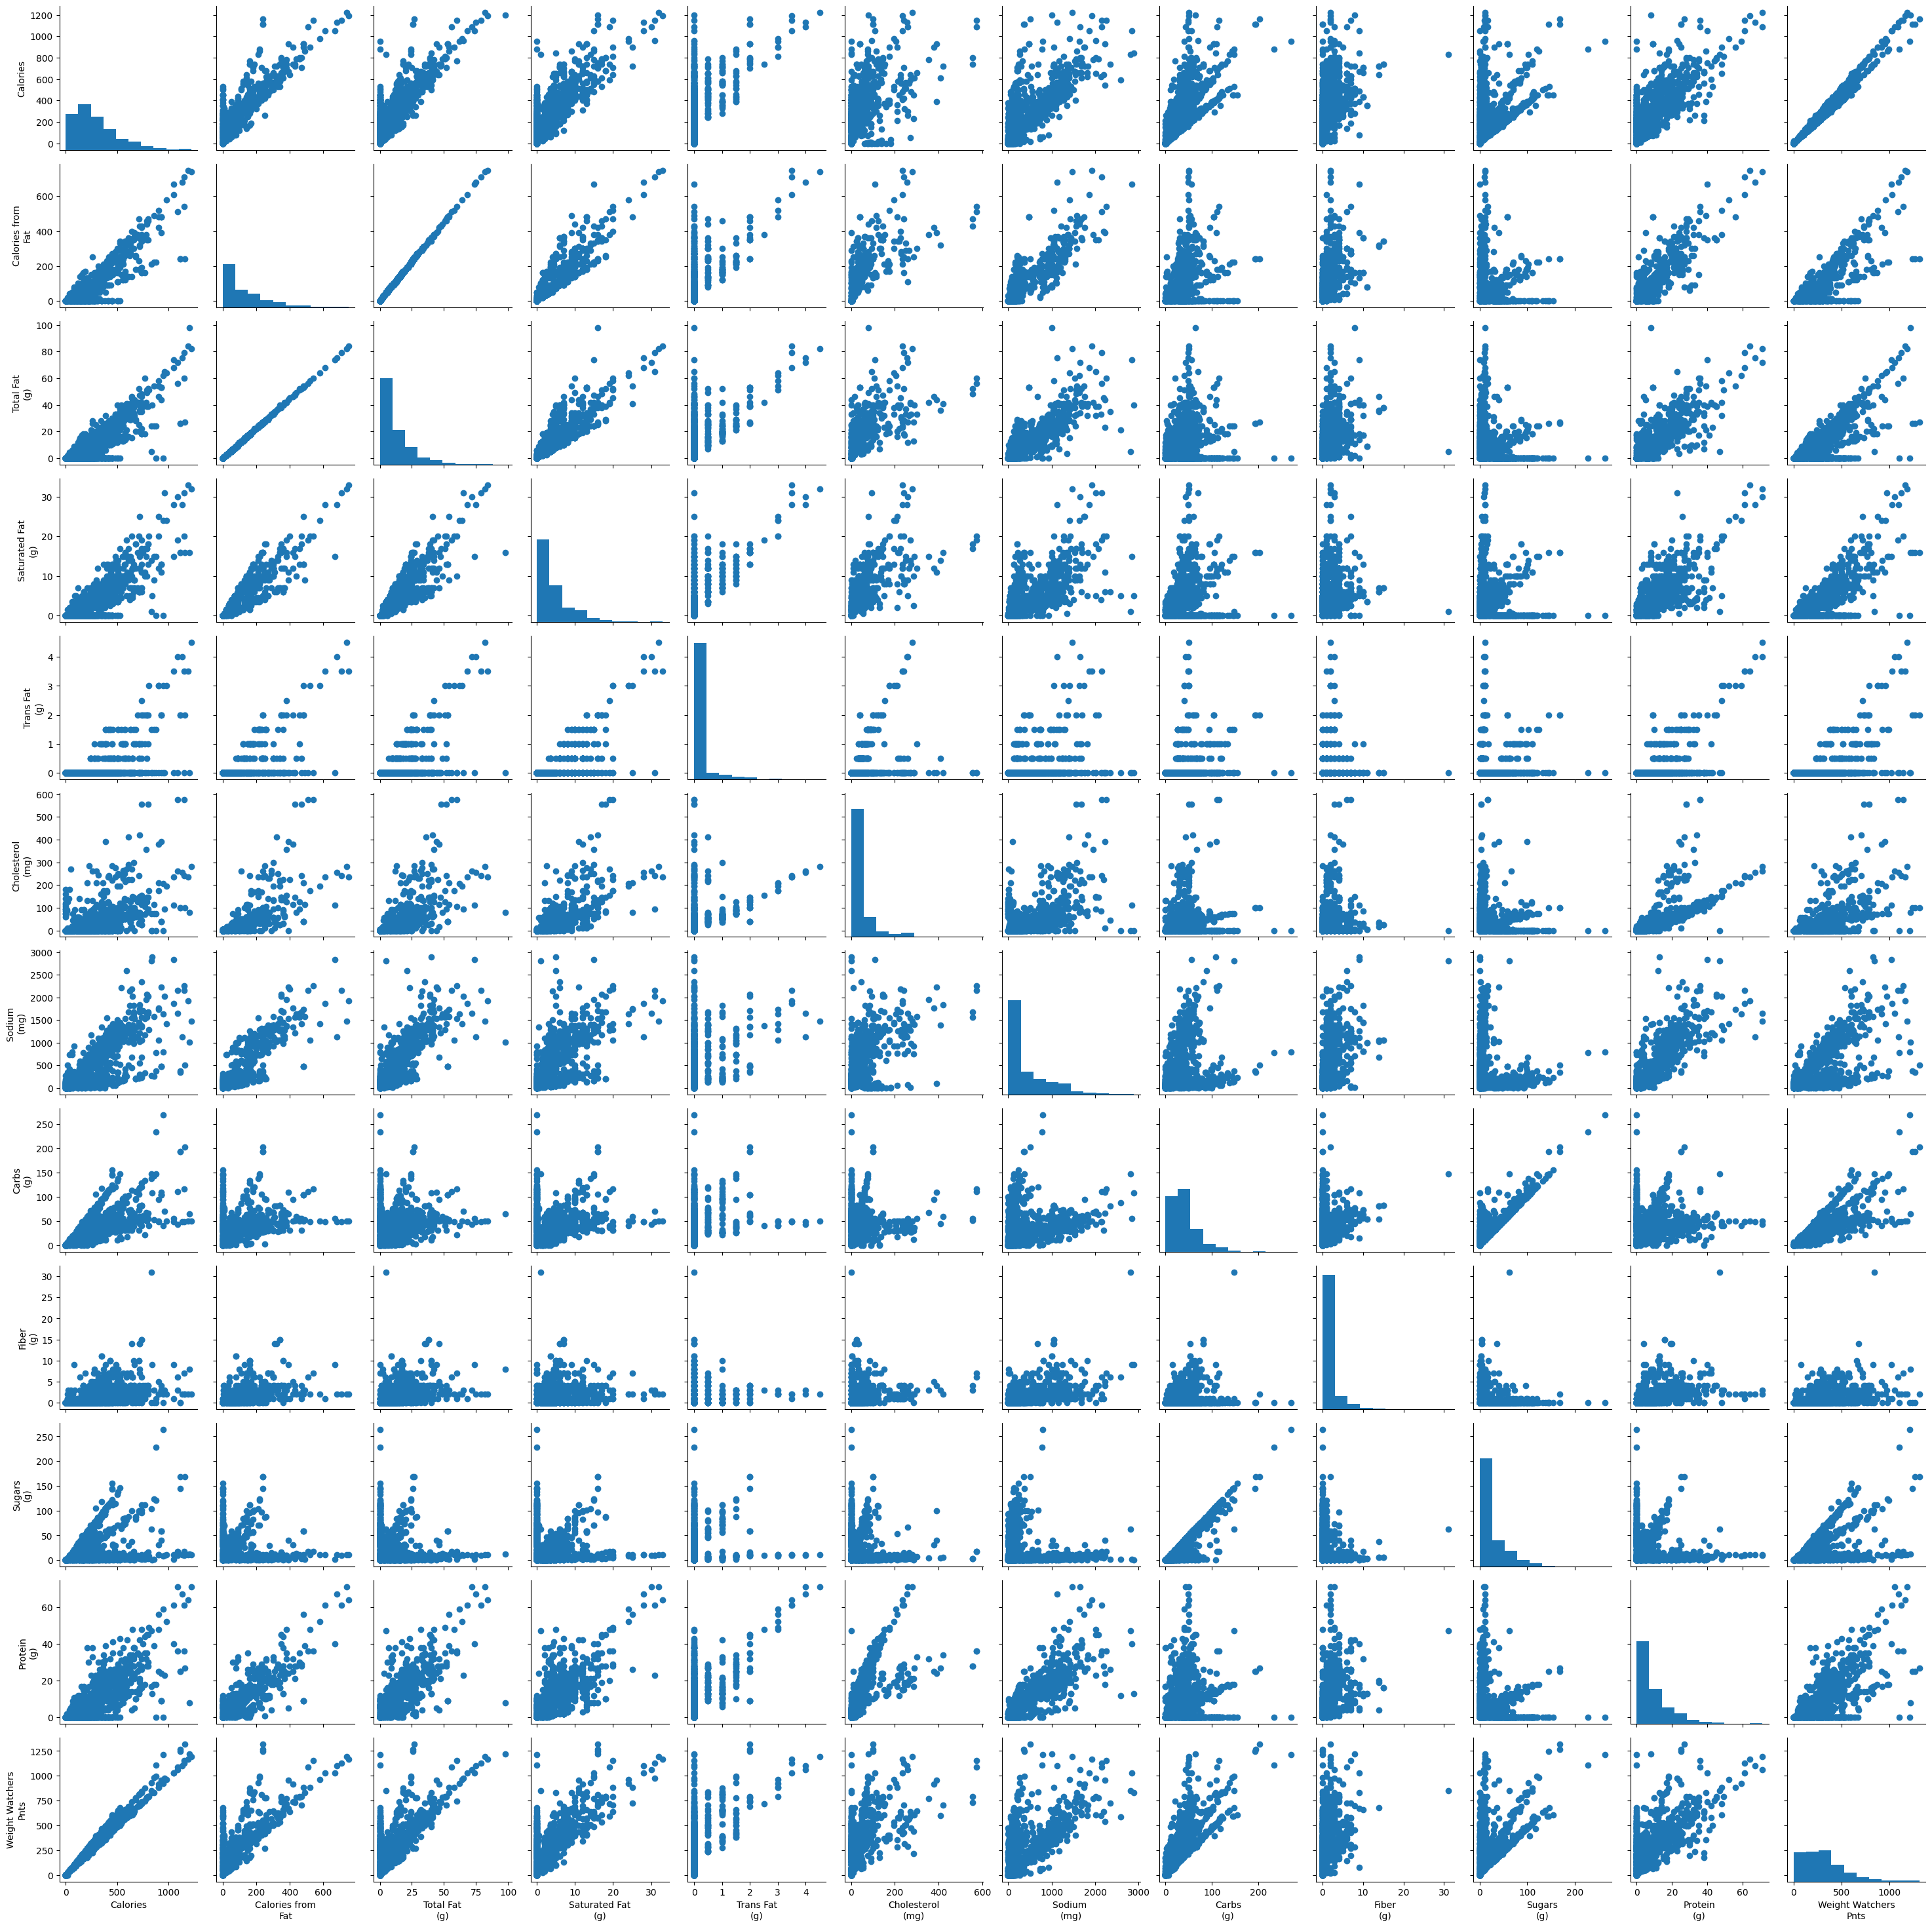

In [9]:
# use seaborn to visualize the pairplot of numeric variables
g = sns.PairGrid(data = fast_food_df, vars = fast_food_df.select_dtypes('number').columns);
g.map_offdiag(plt.scatter);
g.map_diag(plt.hist);

<Axes: >

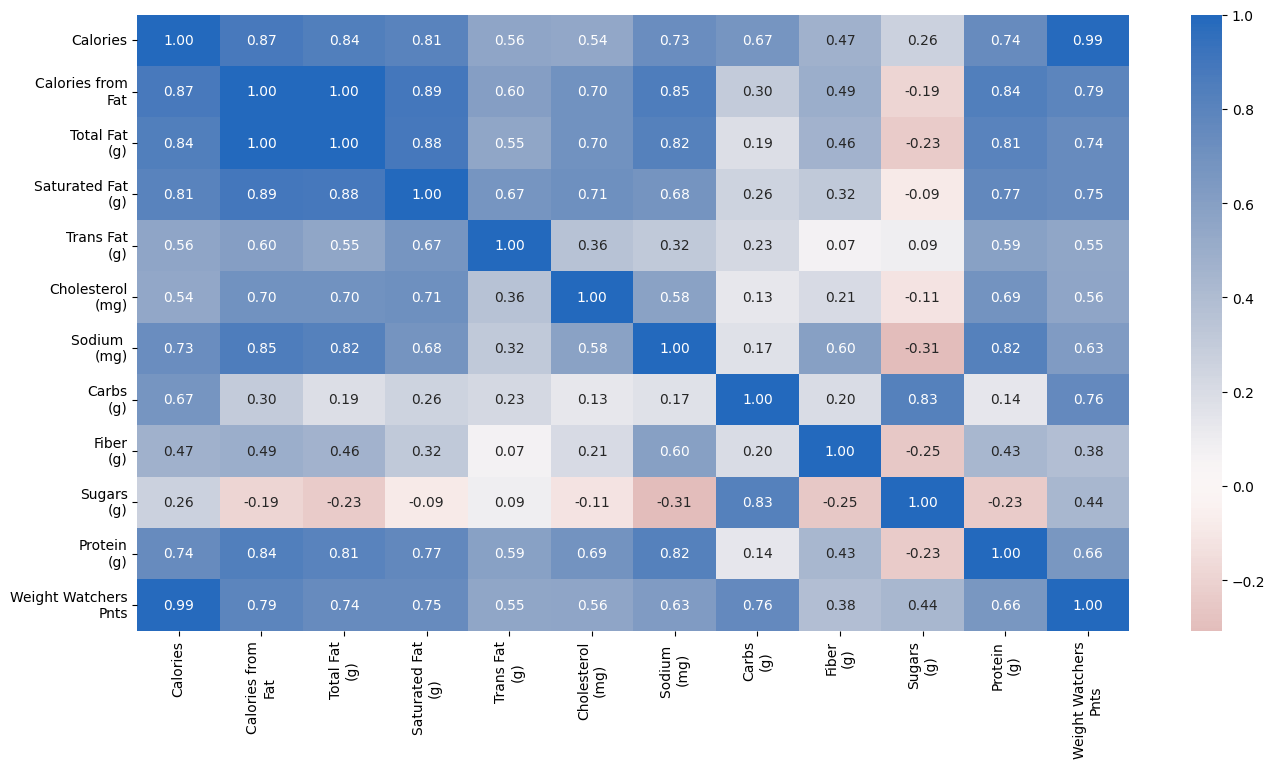

In [10]:
# also visualize the heatmap of the Pearson correlation coefficient
plt.figure(figsize=[16,8])
sns.heatmap(fast_food_df.select_dtypes('number').corr(), annot = True, fmt = '.2f', cmap = 'vlag_r', center = 0)

In [11]:
# sample ten rows from the data to compare weight watcher points and calories
fast_food_df.loc[:, ['Weight Watchers\nPnts', 'Calories']].sample(10, random_state=2021)

,,Weight Watchers\nPnts,Calories
Company,Item,,
McDonald’s,Creamy Ranch Sauce,174.0,170.0
Wendy’s,"Berry Burst Chicken Salad, Full Size",453.0,460.0
McDonald’s,Big Breakfast with Hotcakes (Large Size Biscuit),1151.0,1150.0
Wendy’s,"Natural-Cut Fries, Junior",229.0,230.0
KFC,Lipton® Brisk® Sweet Iced Tea (30 fl oz),254.0,200.0
Burger King,Single Quarter Pound King Sandwich,571.0,580.0
Taco Bell,Nacho Fries BellGrande®,NaN,710.0
Pizza Hut,Hand Tossed Slices Chicken Bacon Parmesan Small,NaN,150.0
Wendy’s,"Vanilla Iced Coffee, Small",198.0,170.0


### Key Takeaway
The Weight Watchers Points shows an almost perfect linear correlation with the number of Calories with correlation coefficient of 0.99. In reality, this is an odd thing to have. Upon inspecting the data itself, we see that the values of Weight Watcher Points and Calories are similar.

In [12]:
# delete the kaggle files created
# LINUX
#! rm -r .kaggle tmp
# WINDOWS
! rmdir /S /Q .kaggle tmp

## New Data
To mitigate against this, we went to the original website where this information was hosted which is [Fast Food Nutrition's](https://fastfoodnutrition.org/ca/) website. We selected five Canadian fast food restaurants from this site and webscraped their nutrition and weight watcher points information. We then updated our code to reflect this new data.

In [13]:
# select five fast food restaurants
restaurants = ['a-w', 'dairy-queen', 'mcdonalds', 'subway', 'tim-hortons']

In [14]:
# create dataframes to store the weight watcher (ww) and nutrition information
ww_df = pd.DataFrame(columns=['Company', 'Category'])
nut_df = pd.DataFrame(columns=['Company', 'Item'])

In [15]:
# looping through each restaurant
for restaurant in restaurants:
    # create the restaurant weight-watchers information URL
    url = f'https://fastfoodnutrition.org/ca/{restaurant}/weight-watchers'
    # send a GET request to the URL using browser user agent headers
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    response = requests.get(url, headers=headers)
    # if the weight watchers URL response is successful
    if response.status_code == 200:
        # parse the response into html
        soup = BeautifulSoup(response.text, 'html.parser')
        # find menu categories
        categories = soup.find_all('h2')
        # find weight watcher points table
        tables = soup.find_all('table', class_='rest_item_list')
        # for all categories and tables in the page
        for category, table in zip(categories, tables):
            # convert the table to a string
            str_content = str(table)
            # read the table into a dataframe
            df = pd.read_html(StringIO(str_content))[0]
            # drop columns and rows that are entirely null
            # rename unnamed column
            df = df.dropna(how='all', axis=1).dropna(how='all', axis=0).rename(columns={'Unnamed: 0': 'Item'})
            # select only rows where weight watcher points are numeric
            df = df[df['FreeStyle Points'].str.isdigit()]
            # insert menu category and restaurant name into the dataframe
            df['Category'] = category.get_text()
            df['Company'] = restaurant
            # add this table to the master weight watchers table created
            ww_df = pd.concat([ww_df, df], axis=0, ignore_index=True)
        
        # find all menu nutrition information hyperlinks
        nutrition_links = soup.find_all('a', class_="btn btn-primary")
        # for all links
        for link in nutrition_links:
            # create the full nutrition info URL
            nutrition_url = f'https://fastfoodnutrition.org/{link.get("href")}'
            # send a GET request to the URL
            nutrition_response = requests.get(nutrition_url, headers=headers)
            # if the nutrition URL response is successful,
            if nutrition_response.status_code == 200:
                # parse the response into html
                nutrition_soup = BeautifulSoup(nutrition_response.text, 'html.parser')
                # find the nutrition information table
                nutrition_contents = nutrition_soup.find('table', class_='item_nutrition')
                # use a try-except to catch errors
                try:
                    # read the table into a dataframe
                    df = pd.read_html(StringIO(str(nutrition_contents)))[0]
                    # set table columns
                    df.columns = ['Nutrient', 'Amount Per Serving', '% Daily Value']
                    # drop irrelevant rows
                    df = df.drop([0, 1, 4])
                    # set calories daily value to null
                    df.iloc[:2, -1] = np.nan
                    # set nutrient as index
                    df.set_index('Nutrient', inplace=True)
                    # Split into two separate DataFrames: one for Amounts and one for % Daily Values
                    df_amounts = df[['Amount Per Serving']].T.add_suffix(' (Amount)')
                    df_daily_values = df[['% Daily Value']].T.add_suffix(' (% Daily Value)')
                    # Combine both into one DataFrame
                    df = pd.concat([df_amounts, df_daily_values], axis=1)
                    # Reset index
                    df.reset_index(drop=True, inplace=True)
                    # coalesce the two rows
                    row1 = df.iloc[0]
                    row2 = df.iloc[1]
                    # Combine the two rows
                    coalesced_row = row1.combine_first(row2)
                    # convert into a dataframe and transpose
                    df = coalesced_row.to_frame().T
                    # insert menu item and restaurant name into the dataframe
                    df['Item'] = link.get("title")
                    df['Company'] = restaurant
                    # add this table into the master nutrition dataframe created
                    nut_df = pd.concat([nut_df, df], axis=0, ignore_index=True)
                # catch errors, inform user, and move to next line
                except:
                    print(f"Failed to retrieve nutrition information for {link.get("href")} for {restaurant}. Status code: {nutrition_response.status_code}")
                    pass
            # if the nutrition URL request was not successful, print the link and its status code
            else:
                print(f"Failed to retrieve nutrition information for {link.get("href")}. Status code: {nutrition_response.status_code}")
    # if the weight watchers URL response is not successful, print the restaurant ans its status code
    else:
        print(f'Failed to retrieve data for {restaurant}. Status code is {response.status_code}')

Failed to retrieve nutrition information for /ca/dairy-queen/butterscotch-dipped-ice-cream-cone/kids for dairy-queen. Status code: 200
Failed to retrieve nutrition information for /ca/dairy-queen/butterscotch-dipped-ice-cream-cone/small for dairy-queen. Status code: 200
Failed to retrieve nutrition information for /ca/dairy-queen/butterscotch-dipped-ice-cream-cone/medium for dairy-queen. Status code: 200
Failed to retrieve nutrition information for /ca/dairy-queen/butterscotch-dipped-ice-cream-cone/large for dairy-queen. Status code: 200
Failed to retrieve nutrition information for /ca/tim-hortons/mocha-iced-coffee for tim-hortons. Status code: 200


### Data Cleaning
Clean the data and make it ready for analysis.

#### Weight Watchers

In [16]:
# drop all null columns
# convert Points columns to float
ww_df.dropna(how='all', axis=1, inplace=True)
ww_df[[col for col in ww_df.columns if 'Points' in col]] = ww_df[[col for col in ww_df.columns if 'Points' in col]].astype(float)

In [17]:
# save to csv
ww_df.to_csv('WeightWatcherPoints.csv', index=False)

#### Nutrition Data

In [18]:
# drop null columns
nut_df.dropna(how='all', axis=1, inplace=True)

In [21]:
# clean item column by removing restaurant name and nutrition suffix
nut_df['Item'] = nut_df['Item'].str.replace('Tim Hortons', 'Tim-Hortons').str.replace('Dairy Queen', 'Dairy-Queen').str.split(' ').apply(lambda  x: ' '.join(x[1:-1]))

In [22]:
# remove Amount suffix from columns
nut_df.columns = nut_df.columns.str.removesuffix(' (Amount)')

In [23]:
# remove % suffix from columns and convert those columns to float
percent_cols = [col for col in nut_df.columns if '%' in col]
for col in percent_cols:
    nut_df[col] = nut_df[col].fillna('0').str.removesuffix('%').astype(float)

In [24]:
# remove g and mg suffixes from columns and convert them to float. Add the suffixes to the column name instead
g_columns = ['Total Fat', 'Saturated Fat', 'Trans Fat', 'Total Carbohydrates', 'Dietary Fiber', 'Sugars', 'Protein']
mg_columns = ['Cholesterol', 'Sodium']
for col in g_columns:
    nut_df[col] = nut_df[col].fillna('0').str.removesuffix('g').astype(float)
    nut_df.rename(columns={f'{col}': f'{col} (g)'}, inplace=True)
for col in mg_columns:
    nut_df[col] = nut_df[col].fillna('0').str.removesuffix('mg').astype(float)
    nut_df.rename(columns={f'{col}': f'{col} (mg)'}, inplace=True)

In [25]:
# save to csv
nut_df.to_csv('NutritionFacts.csv', index=False)

#### Combined Data

In [26]:
# combined both data into one dataframe
df_combined = pd.merge(nut_df, ww_df, how='inner', on=['Company', 'Item'])

In [30]:
# save to csv
df_combined.to_csv('FastFoodNutritionScraped20241011.csv', index=False)

## Creating Data For the Project
In the initial data, we had six restaurants, two of which did not have any weight watcher points. In this new data, we have five restaurants and will remove the weight watcher points of one restaurant (Tim Hortons) which we will be predicting later in the project.

In [31]:
# check numerical summaries of the Weight Watcher Points
df_combined.groupby('Company')[['FreeStyle Points', 'SmartPoints', 'PointsPlus']].agg(['min', 'median', 'mean', 'max'])

FreeStyle Points                         SmartPoints         \
                         min median       mean   max         min median   
Company                                                                   
a-w                      0.0   12.0  13.072072  35.0         0.0   12.0   
dairy-queen              1.0   24.0  26.875556  74.0         2.0   24.0   
mcdonalds                1.0   15.0  17.100719  57.0         1.0   16.0   
subway                   2.0   15.0  15.066667  32.0         2.0   16.0   
tim-hortons              0.0   10.0  10.213333  36.0         0.0   10.0   

                             PointsPlus                          
                  mean   max        min median       mean   max  
Company                                                          
a-w          13.405405  35.0        0.0    9.0   9.567568  24.0  
dairy-queen  27.004444  74.0        2.0   14.0  16.084444  43.0  
mcdonalds    17.748201  57.0        1.0   12.0  12.877698  31.0  
subway       15.622222  32.0        1.0   13.0  13.622222  28.0  
tim-hortons  10.377778  36.0        0.0    7.0   6.711111  18.0

In [32]:
# remove Tim Hortons Weight Watcher Points
df_combined.loc[df_combined['Company'] == 'tim-hortons', ['FreeStyle Points', 'SmartPoints', 'PointsPlus']] = np.nan

In [33]:
# rewrite company names
df_combined['Company'] = df_combined['Company'].replace('a-w', 'a&w').str.replace('-', ' ').str.title()

In [34]:
# save to csv
df_combined.to_csv('FastFoodNutritionScraped20241011V2.csv', index=False)